# 2. Probability Distributions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from prml.distribution import (
    Bernoulli,
    Binomial
)

# Set random seed to make deterministic
np.random.seed(0)

## 2.1 Binary Variables

Consider a single binary random variable $x \in \{0, 1\}$, for instance $x$ might be the outcome of flipping a coin. Then, the probability of heads ($x=1$) can be denoted by a parameter $\mu$ so that,

$$
p(x=1|\mu) = \mu
$$

where $0 \leq \mu \leq 1$. The *Bernoulli* probability distribution over $x$ can therefore be as follows,

$$
\text{Bern}(x|\mu) = \mu^x(1-\mu)^{1-x}
$$

It is easily verified that the Bernoulli distribution has mean given by,

$$
\mathbb{E}[x] = \sum_{x \in \{0, 1\}} x\text{Bern}(x|\mu) =
\sum_{x \in \{0, 1\}} x\mu^x(1-\mu)^{1-x} =
\mu^1(1-\mu)^0 =
\mu
$$

and variance given by,

$$
\begin{align*}
\text{var}[x] &= \mathbb{E}[x]^2 - \mathbb{E}[x^2] \\
&= \mu^2 - \sum_{x \in \{0, 1\}} x^2\text{Bern}(x|\mu) \\
&= \mu^2 - \sum_{x \in \{0, 1\}} x^2\mu^x(1-\mu)^{1-x} \\
&= \mu^2 - \mu = \mu(\mu - 1)
\end{align*}
$$

Now suppose we have given a data set $\mathcal{D} = \{x_1,\dots,x_N\}$ of observed values sampled from an **unknown** Bernoulli distribution, that is, the $\mu$ parameter (probability of heads) is unknown.

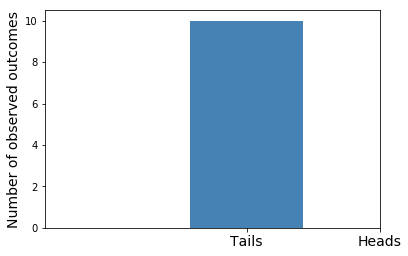

In [2]:
N = 10
mu = 0.25
true_distribution = Bernoulli(mu)
D = true_distribution.draw(N)

plt.hist(D, 2, rwidth=0.85, color="steelblue")
plt.ylabel("Number of observed outcomes", fontsize=14)
plt.xticks([0.25, 0.75], ["Tails", "Heads"], fontsize=14)
plt.show()

We can use the likelihood function on the assumption that the observations are drawn independently from $\text{Bern}(x|\mu)$, so that,

$$
p(\mathcal{D}|\mu) = \prod_{n=1}^N \text{Bern}(x_n|\mu) = \prod_{n=1}^N \mu^{x_n}(1-\mu)^{1-x_n}
$$

Then, following the frequintist approach, we can estimate the value of $\mu$ by maximizing the logarithm of the likelihood given by

$$
\begin{align*}
\ln p(\mathcal{D}|\mu) &= \ln \bigg( \prod_{n=1}^N \mu^{x_n}(1-\mu)^{1-x_n} \bigg) \\
&= \sum_{n=1}^N \ln \big( \mu^{x_n}(1-\mu)^{1-x_n} \big) \\
&= \sum_{n=1}^N \bigg( \ln \big( \mu^{x_n} \big) + \ln \big( (1-\mu)^{1-x_n} \big) \bigg) \\
&= \sum_{n=1}^N \bigg( x_n\ln\mu + (1-x_n)\ln(1-\mu) \bigg) 
\end{align*}
$$

If we set the derivative of $\ln p(\mathcal{D}|\mu)$ with respect to $\mu$ equal to zero, we obtain

$$
\begin{align*}
&\frac{\partial}{\partial\mu} \ln p(\mathcal{D}|\mu) = 0 \Leftrightarrow \\
&\frac{\partial}{\partial\mu} \sum_{n=1}^N \bigg( x_n\ln\mu + (1-x_n)\ln(1-\mu) \bigg) = 0 \Leftrightarrow \\
&\sum_{n=1}^N  \frac{\partial}{\partial\mu} \bigg( x_n\ln\mu + (1-x_n)\ln(1-\mu) \bigg) = 0 \Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1}{\mu}x_n - \frac{1}{1 - \mu}(1-x_n) \bigg) = 0 \Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1}{\mu}x_n - \frac{1}{1 - \mu} + \frac{1}{1 - \mu}x_n \bigg) = 0\Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1}{\mu}x_n + \frac{1}{1 - \mu}x_n \bigg) = \frac{N}{1 - \mu} \Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1 - \mu}{\mu}x_n + x_n \bigg) = N \Leftrightarrow \\
&\sum_{n=1}^N \frac{1}{\mu}x_n = N \Leftrightarrow \\
&\mu_{ML} = \frac{1}{N}\sum_{n=1}^N x_n
\end{align*}
$$

which is known as the *sample mean*. Thus, the probability of landing heads ($\mu$), according to the maximum likelihood estimator, is given by the fraction of observations of heads in the data set $\mathcal{D}$. A problem that arises from this result is that for small datasets the estimation can be unreasonable. For instance, in the figure below, note that for small datasets $N < 100$, the estimated $\mu_{\text{ML}}$ can deviate significantly from the true $\mu$ leading to incorrect probabilities for the future observations.

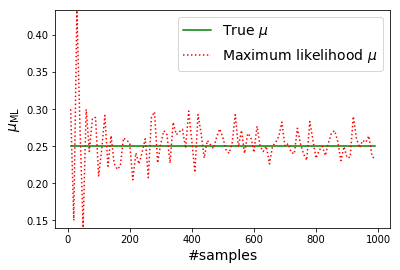

In [3]:
ml_model = Bernoulli()
samples = list(range(10, 1000, 10))
mu_estimations = []

for N in samples:
    D = true_distribution.draw(N)
    ml_model.ml(D)
    mu_estimations.append(ml_model.mu)
    
plt.plot(samples, [mu for N in samples], color="g", label="True $\mu$")
plt.plot(samples, mu_estimations, color="r", linestyle=":", label="Maximum likelihood $\mu$")
plt.xlabel("#samples", fontsize=14); plt.ylabel("$\mu_{\mathrm{ML}}$", fontsize=14)
plt.ylim([min(mu_estimations), max(mu_estimations)])
plt.legend(fontsize=14); plt.show()

Another useful distribution is the one describing the number of $m$ observations of $x=1$ given a sample dataset of size $N$. This is called the *Binomial* distribution, and is given by

$$
\text{Bin}(m|N,\mu) = 
\left(\!
    \begin{array}{c}
      N \\
      m
    \end{array}
\!\right)
\mu^m(1 - \mu)^{N-m}
$$

where

$$
\left(\!
    \begin{array}{c}
      N \\
      m
    \end{array}
\!\right)
= \frac{N!}{(N-m)!m!}
$$

is the numbers of ways of choosing $m$ objects out of a total of $N$ identical objects.

[5 2 3 0 3 2 3 2 1 2]


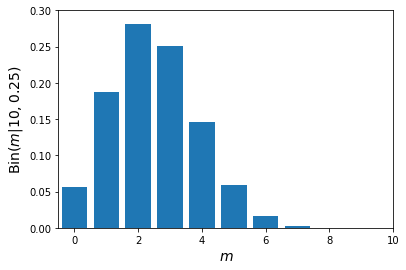

In [9]:
model = Binomial(10, 0.25)
y = model.pdf(np.arange(0, 10))

plt.bar(np.arange(0, 10), y)
plt.xlim([-0.5, 10]); plt.ylim([0, 0.3])
plt.xlabel("$m$", fontsize=14); plt.ylabel("$\mathrm{Bin}(m|10,0.25)$", fontsize=14)
plt.show()

### 2.1.1 The beta distribution